
Classification Report:

                  precision    recall  f1-score   support

Non-Prototrophic       1.00      0.91      0.95        11
    Prototrophic       0.95      1.00      0.97        19

        accuracy                           0.97        30
       macro avg       0.97      0.95      0.96        30
    weighted avg       0.97      0.97      0.97        30



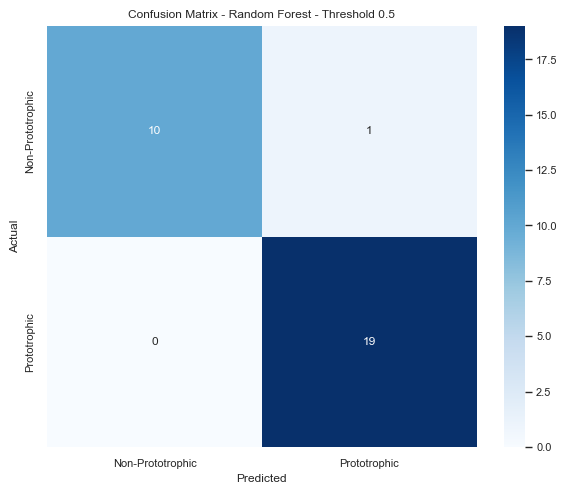

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === Load the data ===
file_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jurkat_Val_RelativeReadCounts_InclValScore.csv"
df = pd.read_csv(file_path)

# === Create binary phenotype ===
df["Prototrophic"] = (df["Val score"] > 0.23).astype(int)

# === Define features and labels ===
feature_cols = df.columns[2:-2]  # Skip 'File', 'Read_Quality', and 'Val score'
X = df[feature_cols].fillna(0)
y = df["Prototrophic"]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

# === Train Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=43)
clf.fit(X_train, y_train)

# === Predict on test set ===
y_pred = clf.predict(X_test)

# === Compute confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
labels = ["Non-Prototrophic", "Prototrophic"]

# === Print classification report ===
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))

# === Plot confusion matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest - Threshold 0.5")
plt.tight_layout()
plt.show()


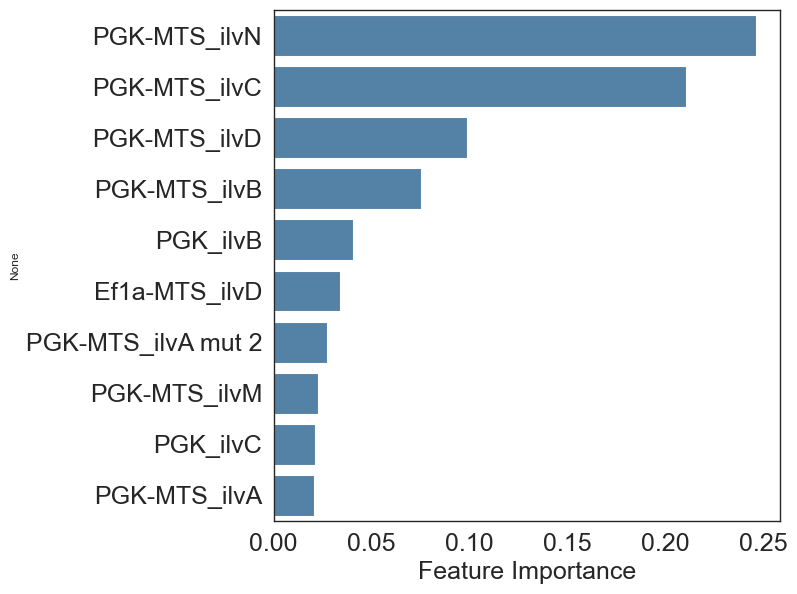

In [11]:
# === Plot Top 10 Feature Importances ===
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(x=importances.head(10), y=importances.head(10).index, color='steelblue')
plt.xlabel("Feature Importance", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.savefig("/Users/trollj01/NYU Langone Health Dropbox/Julie Trolle/Lab/Phylogeny/SGE_Paper/Jupyter_SVGs/top15_feature_importances.svg", dpi=300, bbox_inches='tight')
plt.show()


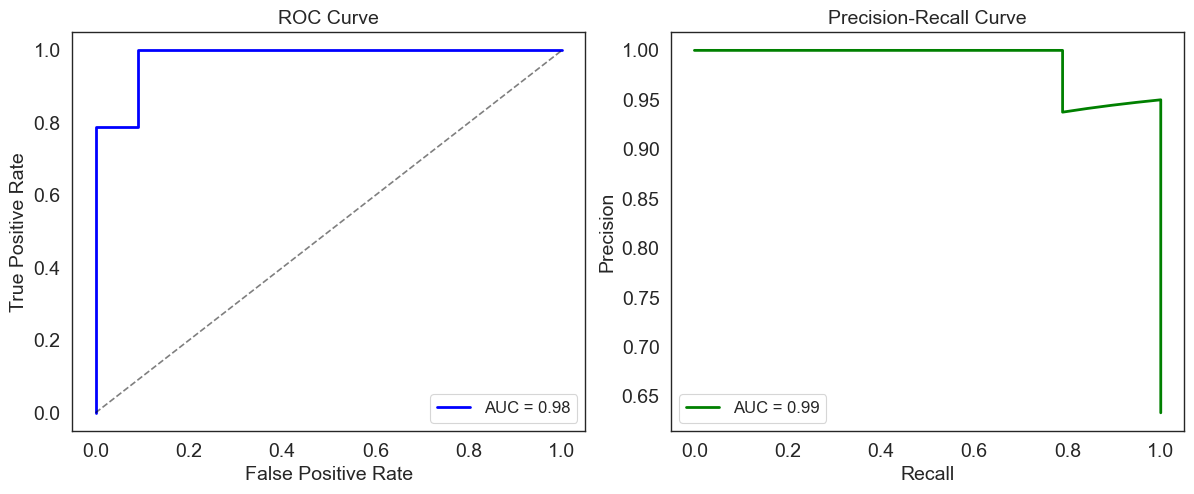

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Get prediction probabilities for class 1 (prototrophic)
y_proba = clf.predict_proba(X_test)[:, 1]

# === ROC Curve and AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# === Precision-Recall Curve and AUC ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# === Plot ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
ax1.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel("False Positive Rate", fontsize=14)
ax1.set_ylabel("True Positive Rate", fontsize=14)
ax1.set_title("ROC Curve", fontsize=14)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', labelsize=14)

# Precision-Recall Curve
ax2.plot(recall, precision, label=f"AUC = {pr_auc:.2f}", color='green', linewidth=2)
ax2.set_xlabel("Recall", fontsize=14)
ax2.set_ylabel("Precision", fontsize=14)
ax2.set_title("Precision-Recall Curve", fontsize=14)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()

# === Save figure to disk ===
plt.savefig("/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/ROC_PR.svg", dpi=300)
plt.show()


=== Cross-validation metrics ===


,Accuracy,ROC AUC,PR AP
Fold,,,
1,0.866667,0.989418,0.995859
2,0.933333,0.984127,0.994048
3,0.966667,1.000000,1.000000
4,1.000000,1.000000,1.000000
Mean,0.941667,0.993386,0.997477
SD,0.049301,0.006873,0.002603


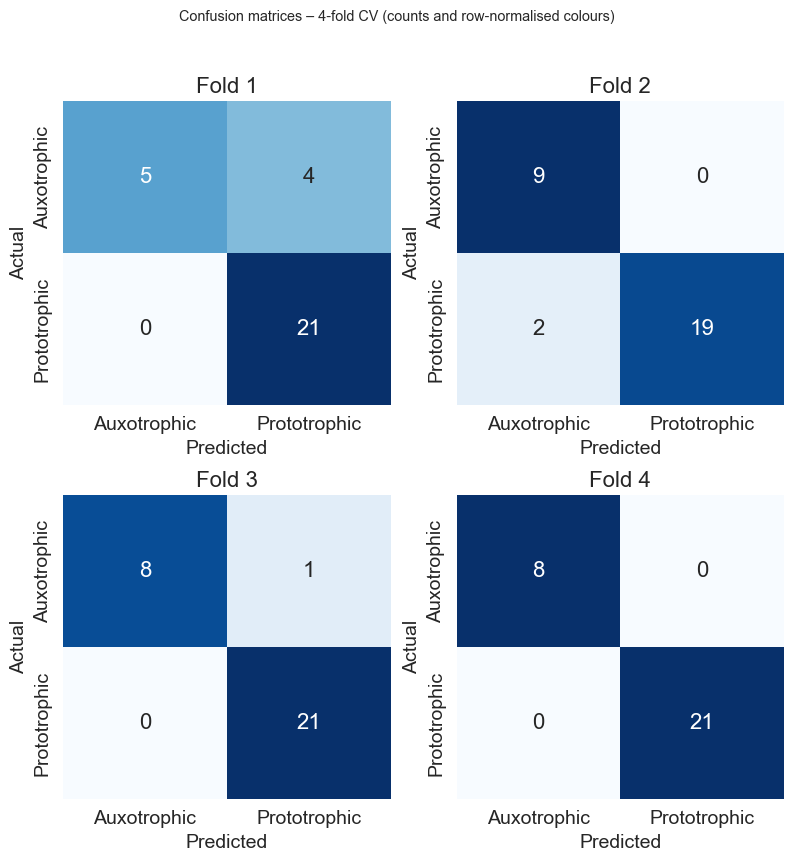

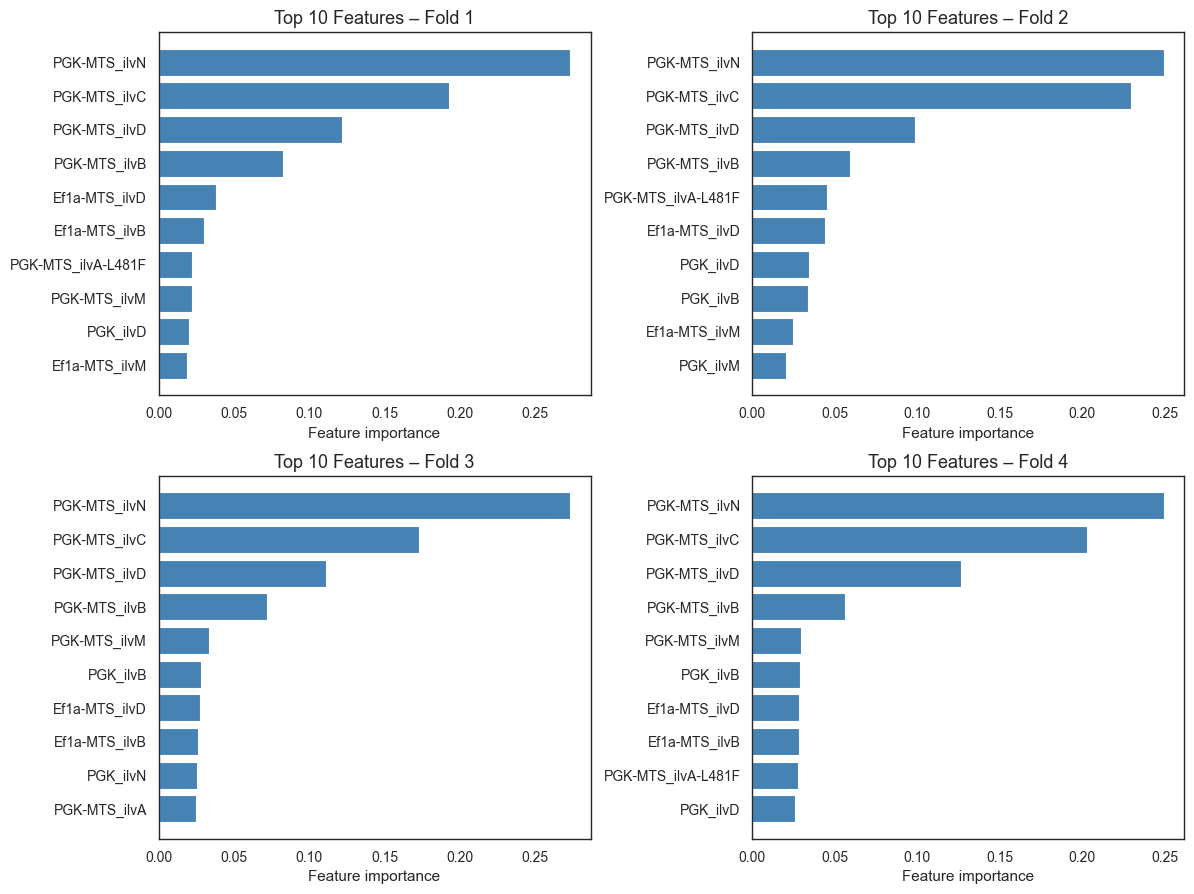

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    roc_auc_score, average_precision_score
)

# ---------- Config ----------
file_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250428_Consolidated_LibJTR012_ALLCLONES/20250428_Jur_Val_RelativeReadCounts_InclValScore.csv"
output_dir = "/Users/trollj01/NYU Langone Health Dropbox/Julie Trolle/Lab/Phylogeny/SGE_Paper"
rename_map = {"PGK-MTS_ilvA mut 2": "PGK-MTS_ilvA-L481F"}
save_figures = True

# ---------- Style ----------
sns.set_style("white")
sns.set_context("paper", font_scale=0.9)
plt.rcParams["axes.facecolor"] = "white"

# ---------- 1. Load data ----------
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found → check `file_path`:\n{file_path}")

df = pd.read_csv(file_path)
df["Prototrophic"] = (df["Val score"] > 0.23).astype(int)
feature_cols = df.columns[2:-2]
X = df[feature_cols].fillna(0)
y = df["Prototrophic"]

# ---------- 2. Run 4-fold CV ----------
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=43)
metrics, cms = [], []
feature_imps = pd.DataFrame(index=feature_cols)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    clf = RandomForestClassifier(n_estimators=100, random_state=43)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    metrics.append({
        "Fold": fold,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "PR AP": average_precision_score(y_test, y_proba)
    })
    cms.append(confusion_matrix(y_test, y_pred, labels=[0, 1]))
    feature_imps[f"Fold_{fold}"] = clf.feature_importances_

# ---------- 3. Display metrics ----------
metrics_df = pd.DataFrame(metrics).set_index("Fold")
metrics_df.loc["Mean"] = metrics_df.mean()
metrics_df.loc["SD"] = metrics_df.std()
print("\n=== Cross-validation metrics ===")
display(metrics_df)

# ---------- 4. Confusion matrix grid ----------
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
axes = axes.ravel()

for ax, cm, fold in zip(axes, cms, range(1, 5)):
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    sns.heatmap(
        cm_norm, annot=cm, fmt="d", cmap="Blues", cbar=False, ax=ax,
        xticklabels=["Auxotrophic", "Prototrophic"],
        yticklabels=["Auxotrophic", "Prototrophic"],
        annot_kws={"size": 16}   # numbers inside cells
    )
    ax.set_title(f"Fold {fold}", fontsize=16)
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)
    ax.tick_params(axis="both", labelsize=14)

fig.suptitle("Confusion matrices – 4-fold CV (counts and row-normalised colours)")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
if save_figures:
    fig.savefig(f"{output_dir}/confusion_matrices_grid.png", dpi=300)
plt.show()

# ---------- 6. Feature importance (top 10) ----------
feature_imps["Mean"] = feature_imps.mean(axis=1)
feature_imps["SD"] = feature_imps.std(axis=1)
top10 = feature_imps.sort_values("Mean", ascending=False).head(10).iloc[::-1]
top10 = top10.rename(index=rename_map)

# ---------- 6b. Top-10 features for each fold ----------
top10_by_fold = {}

for fold_col in [c for c in feature_imps.columns if c.startswith("Fold_")]:
    top10 = (
        feature_imps[fold_col]
        .sort_values(ascending=False)
        .head(10)
        .rename(rename_map)  # apply the same renaming as before
    )
    top10_by_fold[fold_col] = top10

# Combine into a single DataFrame (for compact viewing)
top10_df = pd.DataFrame(top10_by_fold)

# ---------- 6c. Top-10 feature plots for each fold ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 9), facecolor="white")
axes = axes.ravel()

for i, fold_col in enumerate([c for c in feature_imps.columns if c.startswith("Fold_")]):
    top10 = (
        feature_imps[fold_col]
        .sort_values(ascending=False)
        .head(10)
        .iloc[::-1]  # reverse so largest is on top
        .rename(rename_map)
    )

    ax = axes[i]
    ax.barh(top10.index, top10.values, color="steelblue")
    ax.set_title(f"Top 10 Features – {fold_col.replace('_', ' ')}", fontsize=13)
    ax.set_xlabel("Feature importance", fontsize=11)
    ax.tick_params(axis="y", labelsize=10)
    ax.tick_params(axis="x", labelsize=10)

fig.tight_layout()
if save_figures:
    fig.savefig(f"{output_dir}/top10features_per_fold_grid.png", dpi=300)
plt.show()
